# Image classification on CIFAR-100 dataset

In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import os
import numpy as np
from torchvision.utils import make_grid

Image.LOAD_TRUNCATED_IMAGES = True

In [2]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False
    

In [3]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4, padding_mode='reflect'),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5074,0.4867,0.4411], std=[0.2011,0.1987,0.2025])
])

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5074,0.4867,0.4411], std=[0.2011,0.1987,0.2025])
])

In [4]:
train_data = torchvision.datasets.CIFAR100(download=True, root='C:\Cifar-100 dataset', train=True,transform=train_transform)
test_data = torchvision.datasets.CIFAR100(download=True, root='C:\Cifar-100 dataset',train=False,  transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_data, batch_size, num_workers=4,pin_memory=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, pin_memory=True,num_workers=4)

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def show_batch(dl):
    for batch in dl:
        Images, labels = batch
        fig, ax = plt.subplots(figsize=(7.5,7.5))
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(torchvision.utils.make_grid(Images[:20],nrow=5).permute(1,2,0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


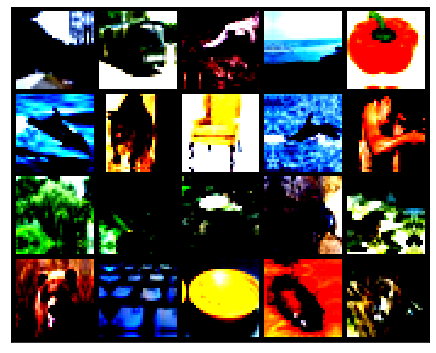

In [7]:
show_batch(train_loader)

In [8]:
device = torch.device("cuda:0")
print(device)

cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


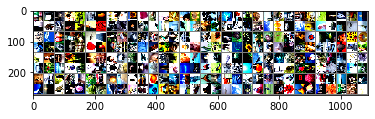

tensor([[[[-0.8461, -0.9436,  0.1290,  ...,  0.1095, -0.5146, -0.5341],
          [-0.8851, -0.6901,  0.3630,  ..., -0.0660, -0.3586, -0.2026],
          [-0.9826, -0.6121,  0.4410,  ..., -0.0660, -0.1050,  0.0705],
          ...,
          [-2.0161, -2.0161, -2.0356,  ..., -0.5341, -0.8851, -0.9826],
          [-0.5536, -0.4756, -0.5731,  ...,  0.3045,  0.2265,  0.3630],
          [ 0.9675,  0.7140,  0.6750,  ...,  1.8060,  1.8255,  1.9230]],

         [[ 0.6492,  0.5110,  1.2610,  ..., -0.1206, -0.7719, -0.9495],
          [ 0.5702,  0.6294,  1.3794,  ..., -0.3969, -0.8311, -0.8903],
          [ 0.1952,  0.3926,  1.2610,  ..., -0.4561, -0.7324, -0.7916],
          ...,
          [-1.8376, -1.8573, -1.8573,  ..., -0.4561, -0.8311, -0.8903],
          [-0.4561, -0.3969, -0.4758,  ...,  0.5307,  0.4321,  0.5307],
          [ 1.0833,  0.8070,  0.7873,  ...,  2.0109,  2.0307,  2.1096]],

         [[-0.1255, -0.2030,  0.8234,  ..., -0.1255, -0.7839, -0.8808],
          [-0.1836, -0.0480,  

In [9]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (2,1,0)))
    plt.show()
    

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))



images

In [31]:
images.size(0)

128

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


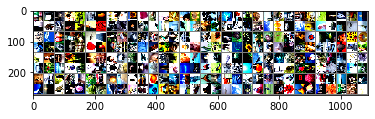

In [10]:
from torch.utils.tensorboard import  SummaryWriter
writer = SummaryWriter('runs/Cifar100latest1.1')

img_grid = torchvision.utils.make_grid(images)

imshow(img_grid)
writer.add_image('fout_cifar100_images', img_grid )


In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
# Transfering data to the device in use (In our case GPU)
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(test_loader, device)

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [15]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet152(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):

        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.conv5 = conv_block(512, 1028, pool=True)
        self.res3 = nn.Sequential(conv_block(1028, 1028), conv_block(1028, 1028))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), 
                                        nn.Flatten(), 
                                        nn.Linear(1028, num_classes))
        

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out
    


In [19]:
model = to_device(ResNet152(3, 100), device=torch.device("cuda:0"))
model

ResNet152(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=

In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 4.605679512023926, 'val_acc': 0.00937500037252903}]

In [21]:
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay =1e-4
opt_func = torch.optim.Adam


In [27]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00279, train_loss: 3.7853, val_loss: 4.0003, val_acc: 0.1798
Epoch [1], last_lr: 0.00760, train_loss: 3.0148, val_loss: 3.0721, val_acc: 0.2991
Epoch [2], last_lr: 0.01000, train_loss: 2.3967, val_loss: 2.4370, val_acc: 0.3795
Epoch [3], last_lr: 0.00950, train_loss: 2.0520, val_loss: 2.1403, val_acc: 0.4270
Epoch [4], last_lr: 0.00812, train_loss: 1.9052, val_loss: 2.2950, val_acc: 0.4028
Epoch [5], last_lr: 0.00611, train_loss: 1.7358, val_loss: 1.7882, val_acc: 0.5139
Epoch [6], last_lr: 0.00389, train_loss: 1.5235, val_loss: 1.6653, val_acc: 0.5509
Epoch [7], last_lr: 0.00188, train_loss: 1.2646, val_loss: 1.3064, val_acc: 0.6308
Epoch [8], last_lr: 0.00050, train_loss: 0.9636, val_loss: 1.1262, val_acc: 0.6759
Epoch [9], last_lr: 0.00000, train_loss: 0.7395, val_loss: 1.0833, val_acc: 0.6896
Wall time: 24min 44s


In [34]:
%%time
history += fit_one_cycle(epochs, 0.001, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00028, train_loss: 0.6924, val_loss: 1.0780, val_acc: 0.6909
Epoch [1], last_lr: 0.00076, train_loss: 0.7093, val_loss: 1.1395, val_acc: 0.6805
Epoch [2], last_lr: 0.00100, train_loss: 0.7364, val_loss: 1.2093, val_acc: 0.6674
Epoch [3], last_lr: 0.00095, train_loss: 0.7055, val_loss: 1.1733, val_acc: 0.6728
Epoch [4], last_lr: 0.00081, train_loss: 0.6298, val_loss: 1.1274, val_acc: 0.6897
Epoch [5], last_lr: 0.00061, train_loss: 0.5401, val_loss: 1.0899, val_acc: 0.7022
Epoch [6], last_lr: 0.00039, train_loss: 0.4314, val_loss: 1.0608, val_acc: 0.7117
Epoch [7], last_lr: 0.00019, train_loss: 0.3484, val_loss: 1.0398, val_acc: 0.7188
Epoch [8], last_lr: 0.00005, train_loss: 0.2822, val_loss: 1.0199, val_acc: 0.7213
Epoch [9], last_lr: 0.00000, train_loss: 0.2533, val_loss: 1.0169, val_acc: 0.7234
Wall time: 22min 39s


In [29]:
%%time
history += fit_one_cycle(4, 0.00001, model, train_dl, valid_dl, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00001, train_loss: 0.2365, val_loss: 1.0197, val_acc: 0.7227
Epoch [1], last_lr: 0.00001, train_loss: 0.2388, val_loss: 1.0164, val_acc: 0.7245
Epoch [2], last_lr: 0.00000, train_loss: 0.2370, val_loss: 1.0165, val_acc: 0.7254
Epoch [3], last_lr: 0.00000, train_loss: 0.2338, val_loss: 1.0152, val_acc: 0.7253
Wall time: 7min 8s


In [24]:
%%time
history += fit_one_cycle(4, 0.0001, model, train_dl, valid_dl, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func )

Epoch [0], last_lr: 0.00009, train_loss: 0.2320, val_loss: 1.0196, val_acc: 0.7240
Epoch [1], last_lr: 0.00008, train_loss: 0.2302, val_loss: 1.0177, val_acc: 0.7276
Epoch [2], last_lr: 0.00003, train_loss: 0.2157, val_loss: 1.0149, val_acc: 0.7287
Epoch [3], last_lr: 0.00000, train_loss: 0.2084, val_loss: 1.0152, val_acc: 0.7283
Wall time: 11min 15s


In [25]:
torch.save(model.state_dict(), 'cifar100-resnet_latest.pth')

In [23]:
model.train()

ResNet152(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=

In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. # of epochs');

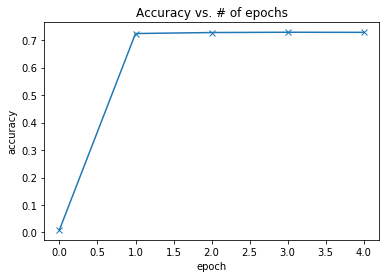

In [27]:
plot_accuracies(history)

In [28]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

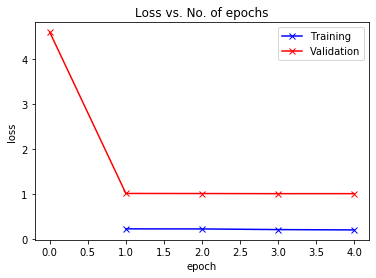

In [29]:
plot_losses(history)

# Testing of Model

In [ ]:
from torchvision.transforms import ToTensor


In [31]:
def predict_img(img, model):
    # convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    
    yb = model(xb)
    
    _, preds = torch.max(yb, dim=1)
    
    return train_data.classes[preds[0].item()]
    

In [39]:
model.eval()

ResNet152(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  bed , Predicted:  bed


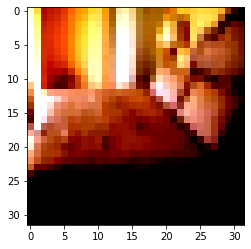

In [53]:
img, label = test_data[459]
plt.imshow(img.permute(1, 2, 0))
print('Label: ', train_data.classes[label], ', Predicted: ', predict_img(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  lion , Predicted:  lion


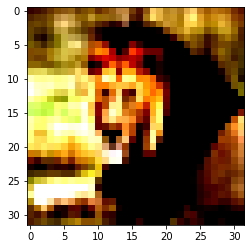

In [66]:
img, label = test_data[117]
plt.imshow(img.permute(1, 2, 0))
print('Label: ', train_data.classes[label], ', Predicted: ', predict_img(img, model))

In [61]:
result = [evaluate(model, valid_dl)]
result

[{'val_loss': 1.0152111053466797, 'val_acc': 0.728320300579071}]

In [62]:
resnet_model = to_device(ResNet152(3, 100), device)


In [63]:
resnet_model.load_state_dict(torch.load('cifar100-resnet_latest.pth'))

<All keys matched successfully>